<a href="https://colab.research.google.com/github/TorAP/AML/blob/main/GenerateMonetFromExcistingModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from datetime import datetime
from PIL import Image
import torchvision.transforms.functional as TF
from io import BytesIO
import torch 
import torch.nn as nn
from PIL import Image
import os
from torch.utils.data import Dataset
import numpy as np
import random, torch, os, numpy as np
import torch.nn as nn
import copy
import albumentations as A
from albumentations.pytorch import ToTensorV2
import sys
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
from torchvision.utils import save_image
import torch
import matplotlib.pyplot as plt
import pandas as pd
import torchvision.transforms as T
import torchvision


from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!unzip drive/My\ Drive/generate.zip

Archive:  drive/My Drive/generate.zip
  inflating: generate/best_model.pth.tar  
  inflating: generate/epoch_100.pth.tar  
  inflating: generate/forest.jpg     
  inflating: generate/glacier.jpg    
  inflating: generate/house.jpg      
  inflating: generate/waterfall.jpg  


In [3]:
FOREST_IMG = "generate/forest.jpg"
GLACIER_IMG = "generate/glacier.jpg"
HOUSE_IMG = "generate/house.jpg"
WATERFALL_IMG = "generate/waterfall.jpg"
BEST_MODEL = "generate/best_model.pth.tar"
HUNDRED_EPOCH_MODEL = "generate/epoch_100.pth.tar"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity()
        )

    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, use_act=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, img_channels, num_features = 64, num_residuals=9):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )
        self.down_blocks = nn.ModuleList(
            [
                ConvBlock(num_features, num_features*2, kernel_size=3, stride=2, padding=1),
                ConvBlock(num_features*2, num_features*4, kernel_size=3, stride=2, padding=1),
            ]
        )
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_features*4) for _ in range(num_residuals)]
        )
        self.up_blocks = nn.ModuleList(
            [
                ConvBlock(num_features*4, num_features*2, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
                ConvBlock(num_features*2, num_features*1, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
            ]
        )

        self.last = nn.Conv2d(num_features*1, img_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect")

    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.res_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))


In [5]:
forest_img = Image.open(FOREST_IMG)
glacier_img = Image.open(GLACIER_IMG)
house_img = Image.open(HOUSE_IMG)
waterfall_img = Image.open(WATERFALL_IMG)



#forest_img = Image.open(FOREST_IMG)
forest_img = TF.to_tensor(forest_img)
forest_img.unsqueeze_(0)
#print(forest_img.shape)

# glacier_img = Image.open(GLACIER_IMG)
glacier_img = TF.to_tensor(glacier_img)
glacier_img.unsqueeze_(0)
# print(glacier_img.shape)

# house_img = Image.open(HOUSE_IMG)
house_img = TF.to_tensor(house_img)
house_img.unsqueeze_(0)
# print(house_img.shape)

# waterfall_img = Image.open(WATERFALL_IMG)
waterfall_img = TF.to_tensor(waterfall_img)
waterfall_img.unsqueeze_(0)
# print(waterfall_img.shape)


gen_M = Generator(img_channels=3, num_residuals=9).to(DEVICE)
checkpoint = torch.load(BEST_MODEL, map_location=DEVICE)
gen_M.load_state_dict(checkpoint["state_dict"])

gen_M_2 = Generator(img_channels=3, num_residuals=9).to(DEVICE)
checkpoint_2 = torch.load(HUNDRED_EPOCH_MODEL, map_location=DEVICE)
gen_M_2.load_state_dict(checkpoint_2["state_dict"])


fake_monet_forest = gen_M(forest_img)
fake_monet_glacier = gen_M(glacier_img)
fake_monet_house = gen_M(house_img)
fake_monet_waterfall = gen_M(waterfall_img)

fake_monet_forest_2 = gen_M_2(forest_img)
fake_monet_glacier_2 = gen_M_2(glacier_img)
fake_monet_house_2 = gen_M_2(house_img)
fake_monet_waterfall_2 = gen_M_2(waterfall_img)



In [6]:
save_image(fake_monet_forest*0.5+0.5, "fake_monet_forest.png")
save_image(fake_monet_glacier*0.5+0.5, "fake_monet_glacier.png")
save_image(fake_monet_house*0.5+0.5, "fake_monet_house.png")
save_image(fake_monet_waterfall*0.5+0.5, "fake_monet_waterfall.png")
save_image(fake_monet_forest_2*0.5+0.5, "fake_monet_forest_2.png")
save_image(fake_monet_glacier_2*0.5+0.5, "fake_monet_glacier_2.png")
save_image(fake_monet_house_2*0.5+0.5, "fake_monet_house_2.png")
save_image(fake_monet_waterfall_2*0.5+0.5, "fake_monet_waterfall_2.png")



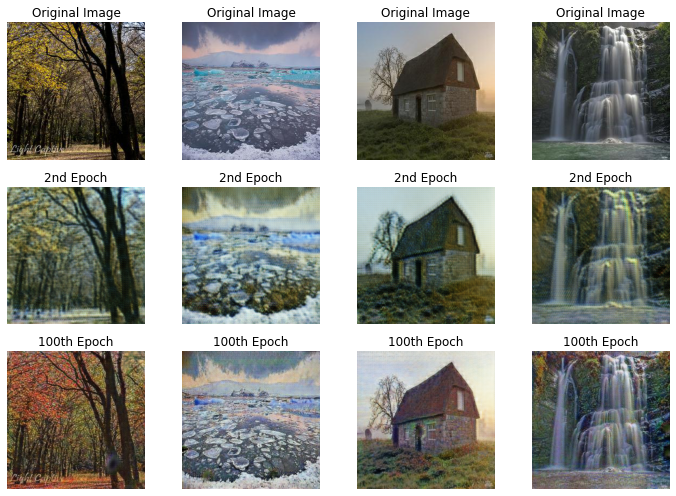

In [8]:
fake_monet_forest = Image.open("fake_monet_forest.png")
fake_monet_glacier = Image.open("fake_monet_glacier.png")
fake_monet_house = Image.open("fake_monet_house.png")
fake_monet_waterfall = Image.open("fake_monet_waterfall.png")

fake_monet_forest_2 = Image.open("fake_monet_forest_2.png")
fake_monet_glacier_2 = Image.open("fake_monet_glacier_2.png")
fake_monet_house_2 = Image.open("fake_monet_house_2.png")
fake_monet_waterfall_2 = Image.open("fake_monet_waterfall_2.png")

forest_img = Image.open(FOREST_IMG)
glacier_img = Image.open(GLACIER_IMG)
house_img = Image.open(HOUSE_IMG)
waterfall_img = Image.open(WATERFALL_IMG)


fig = plt.figure(figsize=(10, 7))


# setting values to rows and column variables
rows = 3
columns = 4

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(forest_img)
plt.axis('off')
plt.title("Original Image")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(glacier_img)
plt.axis('off')
plt.title("Original Image")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(house_img)
plt.axis('off')
plt.title("Original Image")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(waterfall_img)
plt.axis('off')
plt.title("Original Image")
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(fake_monet_forest)
plt.axis('off')
plt.title("2nd Epoch")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 6)
  
# showing image
plt.imshow(fake_monet_glacier)
plt.axis('off')
plt.title("2nd Epoch")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 7)
  
# showing image
plt.imshow(fake_monet_house)
plt.axis('off')
plt.title("2nd Epoch")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 8)
  
# showing image
plt.imshow(fake_monet_waterfall)
plt.axis('off')
plt.title("2nd Epoch")

  # Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 9)
  
# showing image
plt.imshow(fake_monet_forest_2)
plt.axis('off')
plt.title("100th Epoch")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 10)
  
# showing image
plt.imshow(fake_monet_glacier_2)
plt.axis('off')
plt.title("100th Epoch")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 11)
  
# showing image
plt.imshow(fake_monet_house_2)
plt.axis('off')
plt.title("100th Epoch")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 12)
  
# showing image
plt.imshow(fake_monet_waterfall_2)
plt.axis('off')
plt.title("100th Epoch")
fig.tight_layout()
plt.savefig('GeneratedMonets.png')